# ExoJulia
## Andrew Lincowski & Spencer Wallace
## Homework 2

In [17]:
# Required packages
using LsqFit
using PyPlot

LoadError: LoadError: syntax: extra token "as" after end of expression
while loading In[17], in expression starting on line 4

In [44]:
plt[:style][:available]

21-element Array{Any,1}:
 "seaborn-darkgrid"    
 "seaborn-notebook"    
 "seaborn-muted"       
 "seaborn-ticks"       
 "dark_background"     
 "bmh"                 
 "seaborn-talk"        
 "grayscale"           
 "ggplot"              
 "fivethirtyeight"     
 "seaborn-colorblind"  
 "seaborn-deep"        
 "seaborn-whitegrid"   
 "seaborn-bright"      
 "seaborn-poster"      
 "classic"             
 "seaborn-paper"       
 "seaborn-white"       
 "seaborn-pastel"      
 "seaborn-dark"        
 "seaborn-dark-palette"

In [3]:
# Data import
pldata = readdlm("mystery_planet.txt")
time_data = pldata[:,1]
RV_data = pldata[:,2]
err_data = pldata[:,3]

59-element Array{Float64,1}:
 1.0
 1.0
 1.0
 1.3
 1.3
 1.2
 1.1
 1.1
 1.1
 1.2
 1.2
 1.1
 1.2
 ⋮  
 1.0
 1.2
 1.3
 1.3
 1.3
 1.2
 1.3
 1.4
 1.5
 1.2
 1.1
 1.4

# 1. RV Functions

In [4]:
### Define necessary functions ###

### PLANET ORBITAL PERIOD ###

function find_period(time_data,RV_data,showplots=false)
    ### Finds the period of an RV dataset by minimizing sq residuals
    # Showplots option allows outputting useful plots
    
    # Linear period grid using 100,000 datapoints spanning 1 sec to the window width
    period = linspace(1,time_data[end]-time_data[1],100000)
    
    # Initiate other necessary arrays
    sum = Array(Real,length(period))
    phase = Array(Real,length(time_data))

    # Loop over all period guesses
    for (j,P) in enumerate(period)
        sum[j] = 0.0
  
        # Sort by phase given period
        phase = mod(time_data,P)
        
        # Combine phase & RV data as columns
        phase_data_arr = [phase RV_data]
        
        # Sort by phase
        phase_sorted = fastsortrows(phase_data_arr,[1])
        
        # Sum sq residuals
        for i in 2:length(time_data)
            sum[j] += (phase_sorted[i,2]-phase_sorted[i-1,2])*(phase_sorted[i,2]-phase_sorted[i-1,2])
        end
        
    end
    
    min_index = indmin(sum)
    min_per = period[min_index]
    
    # For output of plots describing fit
    if(showplots)
        P = min_per
        sum0 = 0.0
        
        # Sort by phase, given period
        phase = mod(time_data,P)
        
        # Combine arrays
        phase_data_arr = [phase RV_data]
        
        # Sort by phase
        phase_sorted = sortrows(phase_data_arr, by=x->x[1])
        
        # Sum sq residuals
        for i in 2:length(time_data)
            sum0 += (phase_sorted[i,2]-phase_sorted[i-1,2])*(phase_sorted[i,2]-phase_sorted[i-1,2])
        end
        
        # Plot sorted data
        plot(phase_sorted[:,1],phase_sorted[:,2],".")

        # Plot residuals; this component is not currently very flexible
        npts = 2000
        plot(period[min_index-npts:min_index+npts],log10(sum[min_index-npts:min_index+npts]),".")

        else min_per
    end

end

### f value (value of periastron) ###

function f_val(time,ecc,period,time_peri)
    
    M = 2*pi/period*(time-time_peri)
    
    if(length(M) > 1)
        E = Array(Float64,length(M))
        f = Array(Float64,length(M))
        
        for i in 1:length(M)
            E[i] = Orbit.kepler_solve(M[i],ecc)
            f[i] = 2*atan(sqrt((1+ecc)/(1-ecc))*tan(E[i]/2))
        end
        return f 
    else 
        E = Orbit.kepler_solve(M,ecc)
        f = 2*atan(sqrt((1+ecc)/(1-ecc))*tan(E/2))
        return f
    end
end

### ORBITAL ELEMENTS ###

function W_func(err_data)
        
    W = zeros(Float64,length(err_data),length(err_data))
    #W[:,:] = 0.0
    
    for i in 1:length(err_data)
        W[i,i] = (err_data[i])^(-2)
    end
    W
end
        

function B_func(time_data,P,ecc,time_peri)   
    F = Array(Float64,4,length(time_data))

    for i in 1:length(time_data)
        F[1,i] = cos(f_val(time_data[i],ecc,P,time_peri))
        F[2,i] = sin(f_val(time_data[i],ecc,P,time_peri))
        F[3,i] = 1.0
        F[4,i] = time_data[i]-time_data[1]
    end

    B = RV_data'*W*F'*inv(F*W*F')
    return B   
end

### RADIAL VELOCITY FUNCTION ###

function vrad_model(x,p)
    
    # x = time data
        
    ecc = p[1]
    time_peri = p[2]
    P = p[3]
    B = B_func(x,P,ecc,time_peri)
    #B = {h,c,v0,d}
    h = B[1]
    c = B[2]
    v0 = B[3]
    #K = sqrt(h*h + c*c)
    #curlypi = atan(-c/h)
    #gam = v0 - K*ecc*cos(curlypi)
    f = f_val(x,ecc,P,time_peri)
    vrad = h*cos(f) + c*sin(f) + v0
    return vrad

end

function vrad_calc(x,p,B)
    
    # Given parameters, calculate RV
        
    ecc = p[1]
    time_peri = p[2]
    P = p[3]
    #B = {h,c,v0,d}
    h = B[1]
    c = B[2]
    v0 = B[3]
    #K = sqrt(h*h + c*c)
    #curlypi = atan(-c/h)
    #gam = v0 - K*ecc*cos(curlypi)
    f = f_val(x,ecc,P,time_peri)
    vrad = h*cos(f) + c*sin(f) + v0
    return vrad

end

# Traditional sort algorithms are inefficient in Julia :/
# Julia's sort algorithms are even worse.

function fastsortrows(B::AbstractMatrix,cols::Array; kws...)
  """
  Solution by: abhishekmalali (gihub)
  See: https://github.com/JuliaLang/julia/issues/9832
  """
       for i = 1:length(cols)
        if i == 1
            p =sortperm(B[:,cols[i]]; kws...);
            B = B[p,:];
        else
            i0_old = 0;
            i1_old = 0;
            i0_new = 0;
            i1_new = 0;
            for j = 1:size(B,1)-1
                if B[j,cols[1:i-1]] == B[j+1,cols[1:i-1]] && i0_old == i0_new
                    i0_new = j;
                elseif B[j,cols[1:i-1]] != B[j+1,cols[1:i-1]] && i0_old != i0_new && i1_new == i1_old
                    i1_new = j;
                elseif i0_old != i0_new && j == size(B,1)-1
                    i1_new = j+1;
                end
                if i0_new != i0_old && i1_new != i1_old
                    p = sortperm(B[i0_new:i1_new,cols[i]]; kws...);
                    B[i0_new:i1_new,:] = B[i0_new:i1_new,:][p,:];
                    i0_old = i0_new;
                    i1_old = i1_new;
                end
            end
            end
    end
    return B
end

fastsortrows (generic function with 1 method)

# 2. Mystery Planet

In [5]:
#Data import
pldata = readdlm("mystery_planet.txt")
time_data = pldata[:,1]
RV_data = pldata[:,2]
err_data = pldata[:,3]

59-element Array{Float64,1}:
 1.0
 1.0
 1.0
 1.3
 1.3
 1.2
 1.1
 1.1
 1.1
 1.2
 1.2
 1.1
 1.2
 ⋮  
 1.0
 1.2
 1.3
 1.3
 1.3
 1.2
 1.3
 1.4
 1.5
 1.2
 1.1
 1.4

In [6]:
#Probe useful parameter space for period of planet orbit
period = linspace(1,3500,10000)
sum = Array(Real,length(period))

for (j,P) in enumerate(period)
    sum[j] = 0.0
    
    #Sort by phase, given period
    phase = Array(Real,length(time_data))
    phase = mod(time_data,P)
    phase_data_arr = [phase RV_data] #combine arrays
    phase_sorted = fastsortrows(phase_data_arr, [1]) #sort by phase
    for i in 2:length(time_data)
        sum[j] += (phase_sorted[i,2]-phase_sorted[i-1,2])*(phase_sorted[i,2]-phase_sorted[i-1,2])
    end
end

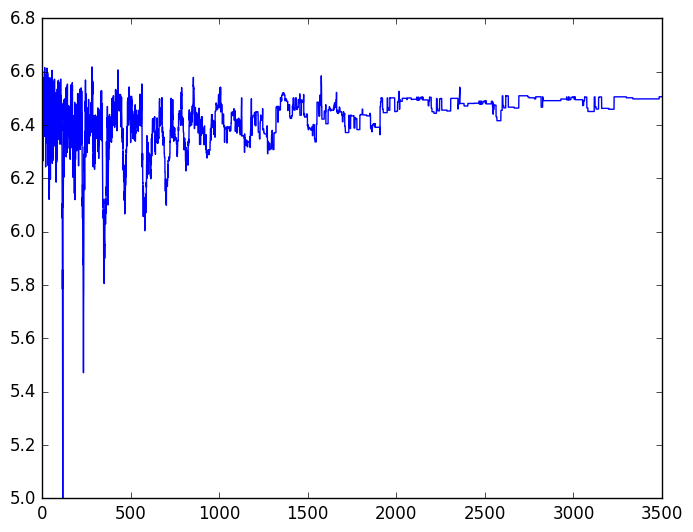

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f51ac1a0a10>

In [7]:
#Plot residuals vs period
plot(period,log10(sum))

We note that the minimum is somewhere around 100-200 days

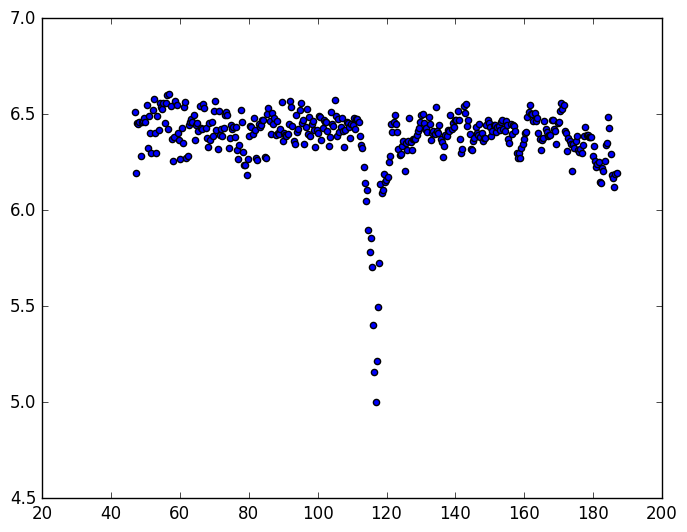

PyObject <matplotlib.collections.PathCollection object at 0x7f51ac0aef90>

In [8]:
#Plot region around minimum of residuals
min_index=indmin(sum)
min_per=period[min_index]
npts = 200
scatter(period[min_index-npts:min_index+npts],log10(sum[min_index-npts:min_index+npts]))

In [9]:
# Period fit (days)
min_per

116.82848284828484

In [10]:
# Calculate phase-sorted RV data
P = min_per
sum = 0.0
#Sort by phase given period
phase = Array(Real,length(time_data))
phase = mod(time_data,P)
phase_data_arr = [phase RV_data] #combine arrays
phase_sorted = fastsortrows(phase_data_arr, [1]) #sort by phase
for i in 2:length(time_data)
    sum += (phase_sorted[i,2]-phase_sorted[i-1,2])*(phase_sorted[i,2]-phase_sorted[i-1,2])
end

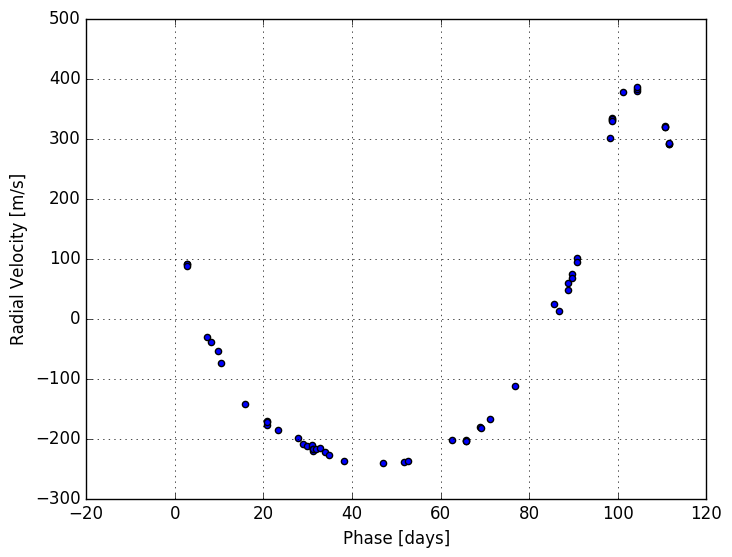

In [11]:
# Plot phase-sorted RV data
scatter(phase_sorted[:,1],phase_sorted[:,2])
xlabel("Phase [days]")
ylabel("Radial Velocity [m/s]")
grid("on")

### K, $\varpi, \gamma$ Analytical Solution

In [12]:
# The prescribed method for importing a module doesn't work in Linux apparently. Ubuntu Julia v.0.4.5
# So we must directly specify the include path.
include("../../../ExoJulia/Orbit/orbit.jl")

Orbit

In [13]:
# Initial values for curve_fit
ecc = 0.0
time_peri = 0.0 #presumably in days
p = [ecc,time_peri,P] #period P from phase folding estimate
W = W_func(err_data) #Must be called W...

# Run fitting routine for eccentricity & time of periastron
fit = curve_fit(vrad_model,time_data,RV_data,err_data,[ecc,time_peri,P])
fit.param

3-element Array{Float64,1}:
   0.40165
   6.27009
 116.681  

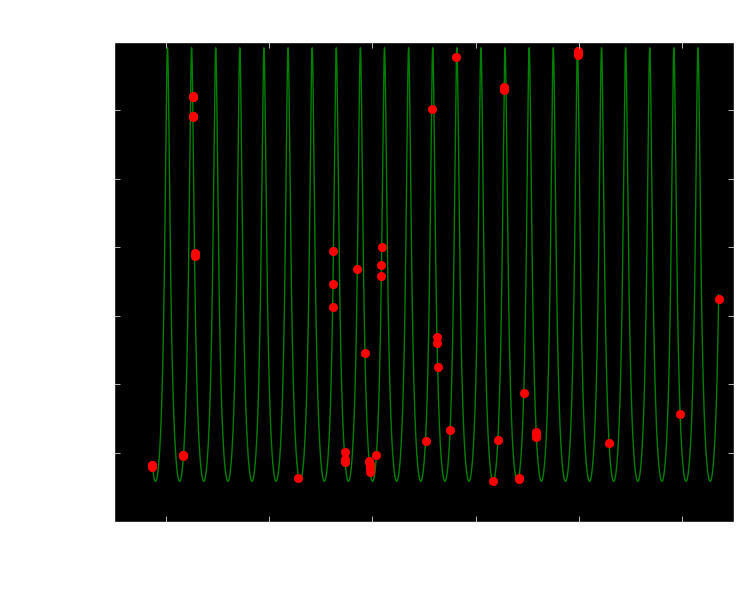

In [62]:

font1 = Dict("family"=>"serif",
"size"=>24, "color"=>"white")

font2 = Dict("family"=>"serif",
    "size"=>18)

# Plot fitted parameters with RV data
time_data_calc = linspace(minimum(time_data),maximum(time_data),10000)
B = B_func(time_data,fit.param[3],fit.param[1],fit.param[2])
p1 = plot(time_data_calc,vrad_calc(time_data_calc,fit.param,B),"g-")

p2 = plot(time_data,RV_data,"r.",markersize=12)
#plt[:style][:use]("dark_background")

xlabel("Time [days]",fontdict=font2)
ylabel("Radial Velocity [m/s]",fontdict=font2)
xlim([13750,16750])
#grid("on")
ax = gca()
title("Radial Velocity Best Fit",fontdict=font1)
setp(ax[:get_yticklabels](),fontsize=18,family="serif")
setp(ax[:get_xticklabels](),fontsize=18,family="serif")
#axis("tight")
#setp(ax[:style][:use]("dark_background"))
savefig("/home/linc/Dropbox/Astronomy/Teaching/2016_Spring_101/RV_fit.eps")

# 3. f & g functions

In [15]:
a = (G*mass*(period/(2*pi))^2)^(1/3)
r0 = (a,0)
v0 = (0,sqrt(G*mass*(2/r0 - 1/a)))

M0 = 2*pi/period*(t0-time_peri)
E0 = Orbit.kepler_solve(M0,ecc)

function f_func(t,t0,E0,M0,a)
    
    M = 2*pi/period*(t-time_peri)
    E = Orbit.kepler_solve(M,ecc) 
    a*(cos(E-E0) + 1)/r0
    
end


function g_func(t,t0,E0,M0)
    
    M = 2*pi/period*(t-time_peri)
    E = Orbit.kepler_solve(M,ecc) 
    (t-t0) + period(sin(E-E0) - (E-E0))/(2*pi)
    
end

LoadError: LoadError: UndefVarError: G not defined
while loading In[15], in expression starting on line 1